## Regression

In this lecture, I will bring together various techniques for feature engineering that we have covered in this course to tackle a regression problem. This would give you an idea of the end-to-end pipeline to build machine learning algorithms for regression.

I will:
- build a lasso
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline

===================================================================================================

## In this demo:

We will use the House Prices dataset, please refer to lecture **Datasets** in Section 1 of the course for instructions on how to download the dataset.

## House Prices dataset

In [56]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### models implemented
from catboost import CatBoostRegressor

pd.pandas.set_option('display.max_columns', None)

### Load Datasets

In [57]:
# load dataset
data = pd.read_csv('houseprice.csv')

print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Types of variables (section 2)

Let's go ahead and find out what types of variables there are in this dataset

In [58]:
# let's inspect the type of variables in pandas

data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

There are a mixture of categorical and numerical variables. Numerical are those of type **int** and **float** and categorical those of type **object**.

In [59]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


Id is a unique identifier for each of the houses. Thus this is not a variable that we can use.

#### Find categorical variables

In [60]:
# find categorical variables

categorical = [var for var in data.columns if data[var].dtype=='O']

print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [61]:
data[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Find temporal variables

There are a few variables in the dataset that are temporal. They indicate the year in which something happened. We shouldn't use these variables straightaway for model building. We should instead transform them to capture some sort of time information. Let's inspect these temporal variables:


In [62]:
# make a list of the numerical variables first
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [63]:
data[year_vars].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


We can see that these variables correspond to the years in which the houses were built or remodeled or a garage was built, or the house was indeed sold. It would be better if we captured the time elapsed between the time the house was built and the time the house was sold for example. We are going to do that in the feature engineering section later in the notebook. 

We have another temporal variable: MoSold, which indicates the month in which the house was sold. Let's inspect if the house price varies with the time of the year in which it is sold:

Text(0, 0.5, 'median House price')

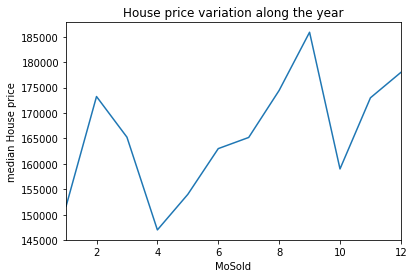

In [64]:
# plot median house price per month in which it was sold

data.groupby('MoSold')['SalePrice'].median().plot()
plt.title('House price variation along the year')
plt.ylabel('median House price')

The price seems to vary depending on the month in which the house is sold.

#### Find discrete variables

To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values. See below.

In [65]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20 and var not in year_vars:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]

There are 14 discrete variables


#### Continuous variables

In [66]:
# find continuous variables
# let's remember to skip the Id variable and the target variable SalePrice
# which are both also numerical

numerical = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 18 numerical and continuous variables


Perfect!! Now we have inspected and have a view of the different types of variables that we have in the house price dataset. Let's move on to understand the types of problems that these variables have.

### Types of problems within the variables (section 3)

#### Missing values

The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build linear regression, we need to tackle these to improve the model performance. To tackle the 2 aspects together, I will do discretisation. I will follow discretisation with encoding of the intervals following the target mean, as we do in the **Discretisation plus encoding lecture** in section 8.

#### Outliers in discrete variables

Now, let's identify outliers in the discrete variables. I will call outliers those values that are present in less than 5 % of the houses. This is exactly the same as finding rare labels in categorical variables. **Discrete variables can be pre-processed / engineered as if they were categorical**. Keep this in mind.

Some of the discrete variables show some sort of monotonic relationship and some don't.

#### Number of labels: cardinality

Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

Text(0, 0.5, 'Number of different categories')

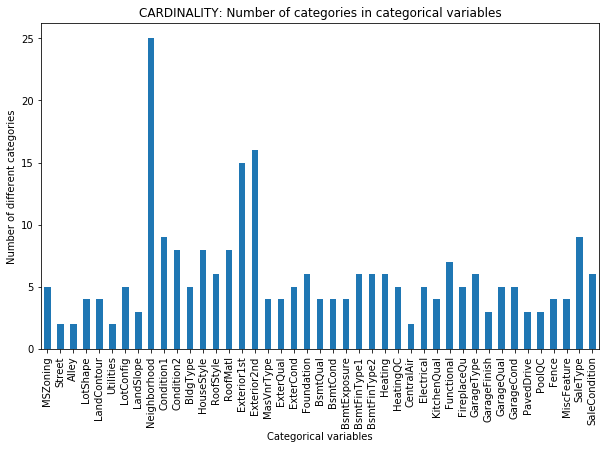

In [68]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

Very likely though, they contain rare labels. Why don't you go ahead and plot the frequency of the categories for each categorical variable? We learned how to do this in section 3 of the course.

### Separate train and test set

In [69]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Temporal variables (Section 12)

First, we will create those temporal variables we discussed a few cells ago

In [70]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [71]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [72]:
X_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


Instead of the "year", now we have the amount of **years that passed** since the house was built or remodeled and the house was sold. Next, we drop the YrSold variable from the datasets, because we already extracted its value.

In [73]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [74]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

### Missing data imputation (section 4)
#### Continuous variables

In [75]:
X_train[categorical].columns 

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [76]:
X_train[discrete].columns

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold'],
      dtype='object')

In [77]:
X_train[numerical].columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'MiscVal'],
      dtype='object')

In [78]:
# print variables with missing data
# keep in mind that now that we created those new temporal variables, we
# are going to treat them as numerical and continuous:

# remove YrSold from the variable list
# because it is no longer in our dataset
year_vars.remove('YrSold')

# examine percentage of missing values
for col in numerical+year_vars:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


Imputation technique to use: **additional variable with NA + median imputation**

Imputation technique to use: **Add missing label to categorical variables**

## Putting it all together

In [79]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [80]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelCategoricalEncoder(
        tol=0.05, n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.OrdinalCategoricalEncoder(
        encoding_method='ordered', variables=categorical+discrete)),

    # discretisation + encoding - section 8
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=numerical)),
    ('encoding', ce.OrdinalCategoricalEncoder(
        encoding_method='ordered', variables=numerical)),

    # feature Scaling - section 10
    #('scaler', StandardScaler()),
    
    # regression
    #('lasso', Lasso(random_state=0))
    ('regression',CatBoostRegressor(max_depth= 6 ,learning_rate=0.01))
])

In [81]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

0:	learn: 78492.8631200	total: 10ms	remaining: 10s
1:	learn: 78036.4657606	total: 15.1ms	remaining: 7.55s
2:	learn: 77580.1351266	total: 19.3ms	remaining: 6.4s
3:	learn: 77081.7529212	total: 22.3ms	remaining: 5.54s
4:	learn: 76640.2747927	total: 25.2ms	remaining: 5.01s
5:	learn: 76160.3720127	total: 27.5ms	remaining: 4.56s
6:	learn: 75649.6701341	total: 29.8ms	remaining: 4.23s
7:	learn: 75198.4546890	total: 32.2ms	remaining: 4s
8:	learn: 74754.3920337	total: 34.8ms	remaining: 3.83s
9:	learn: 74289.2406306	total: 37.2ms	remaining: 3.68s
10:	learn: 73891.4683254	total: 39.8ms	remaining: 3.58s
11:	learn: 73417.1479804	total: 42.2ms	remaining: 3.47s
12:	learn: 72988.6914734	total: 44.5ms	remaining: 3.38s
13:	learn: 72557.2354846	total: 47.1ms	remaining: 3.32s
14:	learn: 72115.3453238	total: 49.7ms	remaining: 3.27s
15:	learn: 71683.3237548	total: 52ms	remaining: 3.2s
16:	learn: 71275.4874147	total: 54.6ms	remaining: 3.15s
17:	learn: 70901.9565791	total: 56.9ms	remaining: 3.1s
18:	learn: 705

214:	learn: 31175.0371624	total: 573ms	remaining: 2.09s
215:	learn: 31108.2526396	total: 579ms	remaining: 2.1s
216:	learn: 31037.8268211	total: 583ms	remaining: 2.1s
217:	learn: 30974.9564063	total: 587ms	remaining: 2.1s
218:	learn: 30901.2716348	total: 592ms	remaining: 2.11s
219:	learn: 30829.8166636	total: 596ms	remaining: 2.11s
220:	learn: 30763.6526740	total: 599ms	remaining: 2.11s
221:	learn: 30702.3508432	total: 603ms	remaining: 2.11s
222:	learn: 30630.6900977	total: 606ms	remaining: 2.11s
223:	learn: 30551.7121187	total: 608ms	remaining: 2.11s
224:	learn: 30468.6607650	total: 611ms	remaining: 2.1s
225:	learn: 30381.5553557	total: 613ms	remaining: 2.1s
226:	learn: 30314.1903725	total: 616ms	remaining: 2.1s
227:	learn: 30233.1751375	total: 618ms	remaining: 2.09s
228:	learn: 30162.5322098	total: 621ms	remaining: 2.09s
229:	learn: 30094.3167606	total: 623ms	remaining: 2.08s
230:	learn: 30017.5942919	total: 625ms	remaining: 2.08s
231:	learn: 29953.7791358	total: 628ms	remaining: 2.08

430:	learn: 22516.1290272	total: 1.1s	remaining: 1.46s
431:	learn: 22497.7554442	total: 1.11s	remaining: 1.46s
432:	learn: 22474.3047943	total: 1.11s	remaining: 1.46s
433:	learn: 22452.8257826	total: 1.12s	remaining: 1.46s
434:	learn: 22428.1925422	total: 1.12s	remaining: 1.46s
435:	learn: 22401.2984686	total: 1.12s	remaining: 1.45s
436:	learn: 22374.9298281	total: 1.13s	remaining: 1.45s
437:	learn: 22354.8510409	total: 1.13s	remaining: 1.45s
438:	learn: 22330.7647728	total: 1.13s	remaining: 1.45s
439:	learn: 22308.7591157	total: 1.13s	remaining: 1.44s
440:	learn: 22293.7382726	total: 1.14s	remaining: 1.44s
441:	learn: 22274.2690694	total: 1.14s	remaining: 1.44s
442:	learn: 22259.7960544	total: 1.14s	remaining: 1.44s
443:	learn: 22240.8793005	total: 1.14s	remaining: 1.43s
444:	learn: 22217.7712949	total: 1.15s	remaining: 1.43s
445:	learn: 22200.3226609	total: 1.15s	remaining: 1.43s
446:	learn: 22186.2580779	total: 1.15s	remaining: 1.42s
447:	learn: 22173.7677812	total: 1.15s	remaining:

583:	learn: 20145.1721786	total: 1.48s	remaining: 1.05s
584:	learn: 20130.8072686	total: 1.48s	remaining: 1.05s
585:	learn: 20119.4036767	total: 1.48s	remaining: 1.05s
586:	learn: 20109.3798931	total: 1.48s	remaining: 1.04s
587:	learn: 20100.4068506	total: 1.49s	remaining: 1.04s
588:	learn: 20095.3639348	total: 1.49s	remaining: 1.04s
589:	learn: 20082.0167356	total: 1.49s	remaining: 1.04s
590:	learn: 20074.4976838	total: 1.5s	remaining: 1.03s
591:	learn: 20065.4963750	total: 1.5s	remaining: 1.03s
592:	learn: 20057.3500814	total: 1.5s	remaining: 1.03s
593:	learn: 20042.0001860	total: 1.5s	remaining: 1.03s
594:	learn: 20030.7741513	total: 1.5s	remaining: 1.02s
595:	learn: 20022.6104276	total: 1.51s	remaining: 1.02s
596:	learn: 20008.5859775	total: 1.51s	remaining: 1.02s
597:	learn: 19999.2689285	total: 1.51s	remaining: 1.02s
598:	learn: 19990.6799678	total: 1.51s	remaining: 1.01s
599:	learn: 19979.3411647	total: 1.52s	remaining: 1.01s
600:	learn: 19967.1137725	total: 1.52s	remaining: 1.0

736:	learn: 18653.2367763	total: 1.83s	remaining: 654ms
737:	learn: 18638.9795157	total: 1.83s	remaining: 652ms
738:	learn: 18630.2394882	total: 1.84s	remaining: 649ms
739:	learn: 18621.2264778	total: 1.84s	remaining: 647ms
740:	learn: 18611.3989410	total: 1.84s	remaining: 645ms
741:	learn: 18605.4994310	total: 1.85s	remaining: 642ms
742:	learn: 18602.9606237	total: 1.85s	remaining: 640ms
743:	learn: 18595.2216468	total: 1.85s	remaining: 637ms
744:	learn: 18589.6812927	total: 1.85s	remaining: 635ms
745:	learn: 18579.8846548	total: 1.86s	remaining: 632ms
746:	learn: 18575.9890684	total: 1.86s	remaining: 629ms
747:	learn: 18570.3197524	total: 1.86s	remaining: 627ms
748:	learn: 18557.7656140	total: 1.86s	remaining: 624ms
749:	learn: 18547.7949511	total: 1.86s	remaining: 622ms
750:	learn: 18539.7425886	total: 1.87s	remaining: 619ms
751:	learn: 18529.9859578	total: 1.87s	remaining: 617ms
752:	learn: 18523.9505023	total: 1.87s	remaining: 614ms
753:	learn: 18517.0584725	total: 1.87s	remaining

890:	learn: 17440.7347249	total: 2.19s	remaining: 268ms
891:	learn: 17438.8016515	total: 2.19s	remaining: 266ms
892:	learn: 17433.8606435	total: 2.2s	remaining: 263ms
893:	learn: 17430.3560800	total: 2.2s	remaining: 261ms
894:	learn: 17422.6680453	total: 2.2s	remaining: 258ms
895:	learn: 17416.3526076	total: 2.21s	remaining: 256ms
896:	learn: 17409.4377039	total: 2.21s	remaining: 254ms
897:	learn: 17408.7690071	total: 2.21s	remaining: 251ms
898:	learn: 17403.0280005	total: 2.21s	remaining: 249ms
899:	learn: 17398.1446037	total: 2.21s	remaining: 246ms
900:	learn: 17392.9056478	total: 2.22s	remaining: 244ms
901:	learn: 17381.6187056	total: 2.22s	remaining: 241ms
902:	learn: 17374.4565421	total: 2.22s	remaining: 239ms
903:	learn: 17373.9503515	total: 2.22s	remaining: 236ms
904:	learn: 17363.7756038	total: 2.23s	remaining: 234ms
905:	learn: 17358.8706615	total: 2.23s	remaining: 231ms
906:	learn: 17352.8576885	total: 2.23s	remaining: 229ms
907:	learn: 17345.4154884	total: 2.23s	remaining: 2

In [82]:
# a peek into the prediction values
X_train_preds

array([216595.58642965, 155048.0686069 , 305363.90454351, ...,
       127141.59757094, 203321.04718923, 205832.89137801])

In [83]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 282077044.44065934
train rmse: 16795.149431924066
train r2: 0.9548230878062501

test mse: 924494738.3882022
test rmse: 30405.50506714536
test r2: 0.8654715906492172


Text(0, 0.5, 'Predicted Price')

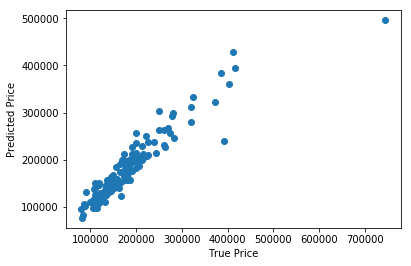

In [84]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

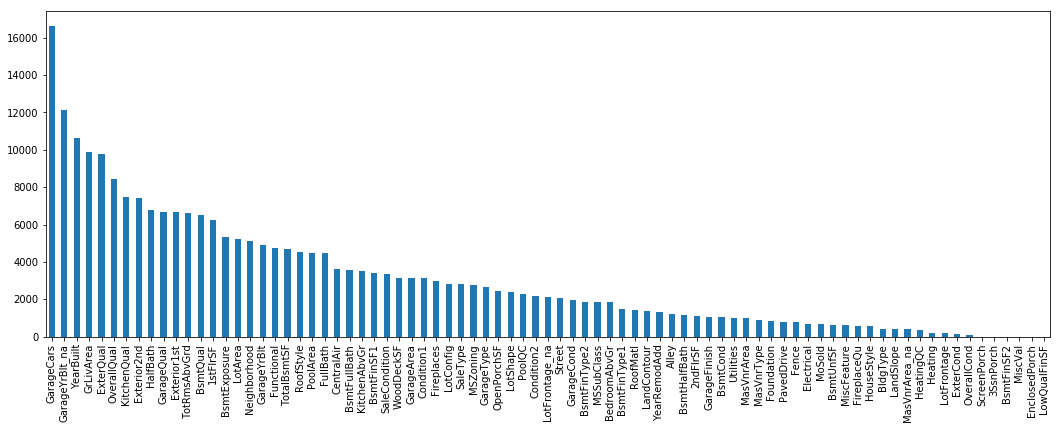

In [31]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['regression'].  ))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))